In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

BATCH_SIZE = 64
NUM_EPOCHS = 10

In [2]:
train_data = MNIST(root="data", train=True, transform=ToTensor(), download=True)

train_size = int(0.8*len(train_data))
val_size = len(train_data) - train_size
train_data, val_data = random_split(train_data, [train_size, val_size])

test_data = MNIST(root="data", train=False, transform=ToTensor(), download=True)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [3]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3)
        self.pool = nn.MaxPool2d(2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(1600, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = Net().to(device)

In [4]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

def train(loader):
    model.train()
    total_train_loss = 0.0
    correct = 0

    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        total_train_loss += loss.item() * inputs.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        loss.backward()
        optimizer.step()

    avg_loss = total_train_loss / len(loader.dataset)
    accuracy = 100 * correct / len(loader.dataset)
    return avg_loss, accuracy

def evaluate(loader):
    model.eval()
    total_loss = 0.0
    correct = 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()

    avg_loss = total_loss / len(loader.dataset)
    accuracy = 100 * correct / len(loader.dataset)
    return avg_loss, accuracy

In [5]:
train_losses = []
train_accs = []
val_losses = []
val_accs = []

for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = train(train_loader)
    val_loss, val_acc = evaluate(val_loader)

    print(
        f"Epoch [{epoch+1}/{NUM_EPOCHS}] "
        f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
        f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%"
    )

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

test_loss, test_acc = evaluate(test_loader)
print(f"Final Test Accuracy: {test_acc:.2f}%")

Epoch [1/10] Train Loss: 0.2423 | Train Acc: 92.24% | Val Loss: 0.0669 | Val Acc: 98.06%
Epoch [2/10] Train Loss: 0.0750 | Train Acc: 97.72% | Val Loss: 0.0412 | Val Acc: 98.72%
Epoch [3/10] Train Loss: 0.0549 | Train Acc: 98.33% | Val Loss: 0.0389 | Val Acc: 98.82%
Epoch [4/10] Train Loss: 0.0435 | Train Acc: 98.64% | Val Loss: 0.0339 | Val Acc: 99.08%
Epoch [5/10] Train Loss: 0.0380 | Train Acc: 98.81% | Val Loss: 0.0339 | Val Acc: 99.02%
Epoch [6/10] Train Loss: 0.0308 | Train Acc: 99.02% | Val Loss: 0.0347 | Val Acc: 99.06%
Epoch [7/10] Train Loss: 0.0270 | Train Acc: 99.12% | Val Loss: 0.0366 | Val Acc: 99.12%
Epoch [8/10] Train Loss: 0.0242 | Train Acc: 99.22% | Val Loss: 0.0284 | Val Acc: 99.17%
Epoch [9/10] Train Loss: 0.0231 | Train Acc: 99.25% | Val Loss: 0.0324 | Val Acc: 99.17%
Epoch [10/10] Train Loss: 0.0170 | Train Acc: 99.47% | Val Loss: 0.0305 | Val Acc: 99.28%
Final Test Accuracy: 99.27%


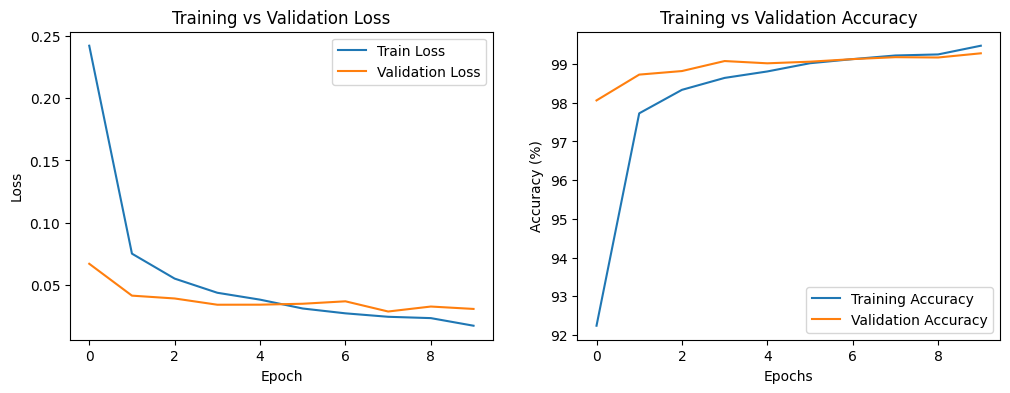

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

ax1.plot(train_losses, label="Train Loss")
ax1.plot(val_losses, label="Validation Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.set_title("Training vs Validation Loss")
ax1.legend()

ax2.plot(train_accs, label="Training Accuracy")
ax2.plot(val_accs, label="Validation Accuracy")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy (%)")
ax2.set_title("Training vs Validation Accuracy")
ax2.legend()

plt.show()